In [1]:
!pip install -U scikit-learn
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn
xgb.__version__

'1.6.0'

In [2]:
df = pd.read_csv("training.csv",index_col=0)
df["y"] = (df.iloc[:,-1]=="s").astype(int)
np.random.seed(0)
sample = df.loc[np.random.choice(df.index, 10000)]
X = sample.drop(['Label', 'y', 'Weight'], axis=1)
y = sample["y"]

In [3]:
# Here we do not need to deal with the missing values which is set to -999, as here missing value are representing lacking of a physical object rather simply lossing data.
# imp = SimpleImputer(missing_values=-999, strategy='constant', fill_value=0)
# X = imp.fit_transform(X)
# standardize 
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

In [4]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=.25, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, test_size=.5, random_state=0)

# Hyperparameter tuning
We used gradient boosting decision tree, random forest, KNN, and Extreme Gradient Boosting decision tree. Grid search is applied for hyperparameter tuning. Three fold cross validation is used as computing power and time is limited.

In [9]:
%%time
parameters = {'max_depth':range(2,10)}
clf = GridSearchCV(RandomForestClassifier(), parameters, cv=3, verbose=3, n_jobs=8)
clf.fit(X_train, y_train)
print(clf.best_score_,clf.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
0.8329333333333334 {'max_depth': 8}
Wall time: 5.5 s


In [10]:
%%time
parameters = {'n_neighbors':range(4,200),'metric':['manhattan']} #Using manhattan metric for high-dimensional feature vectors
clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=3, verbose=3, n_jobs=8)
clf.fit(X_train, y_train)
print(clf.best_score_,clf.best_params_)

Fitting 3 folds for each of 196 candidates, totalling 588 fits
0.7814666666666668 {'metric': 'manhattan', 'n_neighbors': 45}
Wall time: 40.7 s


In [11]:
%%time
parameters = {'n_estimators':[100, 500, 1000], 'learning_rate':[0.1, 0.05, 0.01],
             'max_depth':[3, 4, 5, 6, 7]}
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, verbose=3, n_jobs=8)
clf.fit(X_train, y_train)
print(clf.best_score_,clf.best_params_)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
0.8376000000000001 {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}
Wall time: 8min 39s


In [13]:
%%time
parameters = {'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [6, 7, 8, 9],
              'min_child_weight': [0.0001],
              'subsample': [0.8],
              'colsample_bytree': [0.3,0.5,0.7],
              'n_estimators': [100, 500, 1000],
              'missing':[-999],
              'seed': [1337],
              'use_label_encoder':[False],
              'eval_metric':['rmse'],
              'booster':['gbtree'],
              'verbosity':[0]}
clf = GridSearchCV(xgb.XGBClassifier(), parameters, cv=3, verbose=3, n_jobs=8)
clf.fit(X_train, y_train)
print(clf.best_score_,clf.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
0.8403999999999999 {'booster': 'gbtree', 'colsample_bytree': 0.7, 'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 0.0001, 'missing': -999, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1337, 'subsample': 0.8, 'use_label_encoder': False, 'verbosity': 0}
Wall time: 7min 43s


In [34]:
%%time
RFC = RandomForestClassifier(max_depth=8, random_state=0)
RFC.fit(X_train, y_train)
RFC.score(X_valid, y_valid)

Wall time: 1.1 s


0.8368

In [35]:
%%time
knn = KNeighborsClassifier(n_neighbors=45, metric='manhattan')
knn.fit(X_train, y_train)
knn.score(X_valid, y_valid)

Wall time: 264 ms


0.7744

In [7]:
%%time
GBC = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1,
    max_depth=6, random_state=0)
GBC.fit(X_train, y_train)
GBC.score(X_valid, y_valid)

Wall time: 35.7 s


0.8256

In [37]:
%%time
xgb_model = xgb.XGBClassifier(
    learning_rate     = 0.01,
    max_depth         = 7,
    n_estimators      = 1000,
    objective         = 'binary:logistic',
    base_score        = 0.5,
    booster           = 'gbtree',
    colsample_bytree  = 0.7,
    gamma             = 0,
    min_child_weight  = 0.0001,
    nthread           = 4,
    random_state      = 0,
    seed              = 1337,
    eval_metric       ='rmse',
    use_label_encoder = False,
    verbosity         = 0,
    tree_method       = 'gpu_hist',
    gpu_id            = 0,
    subsample         = 0.8
)
xgb_model.fit(X_train, y_train)
xgb_model.score(X_valid, y_valid)

Wall time: 10.1 s


0.8376

0.8352
Wall time: 19 s


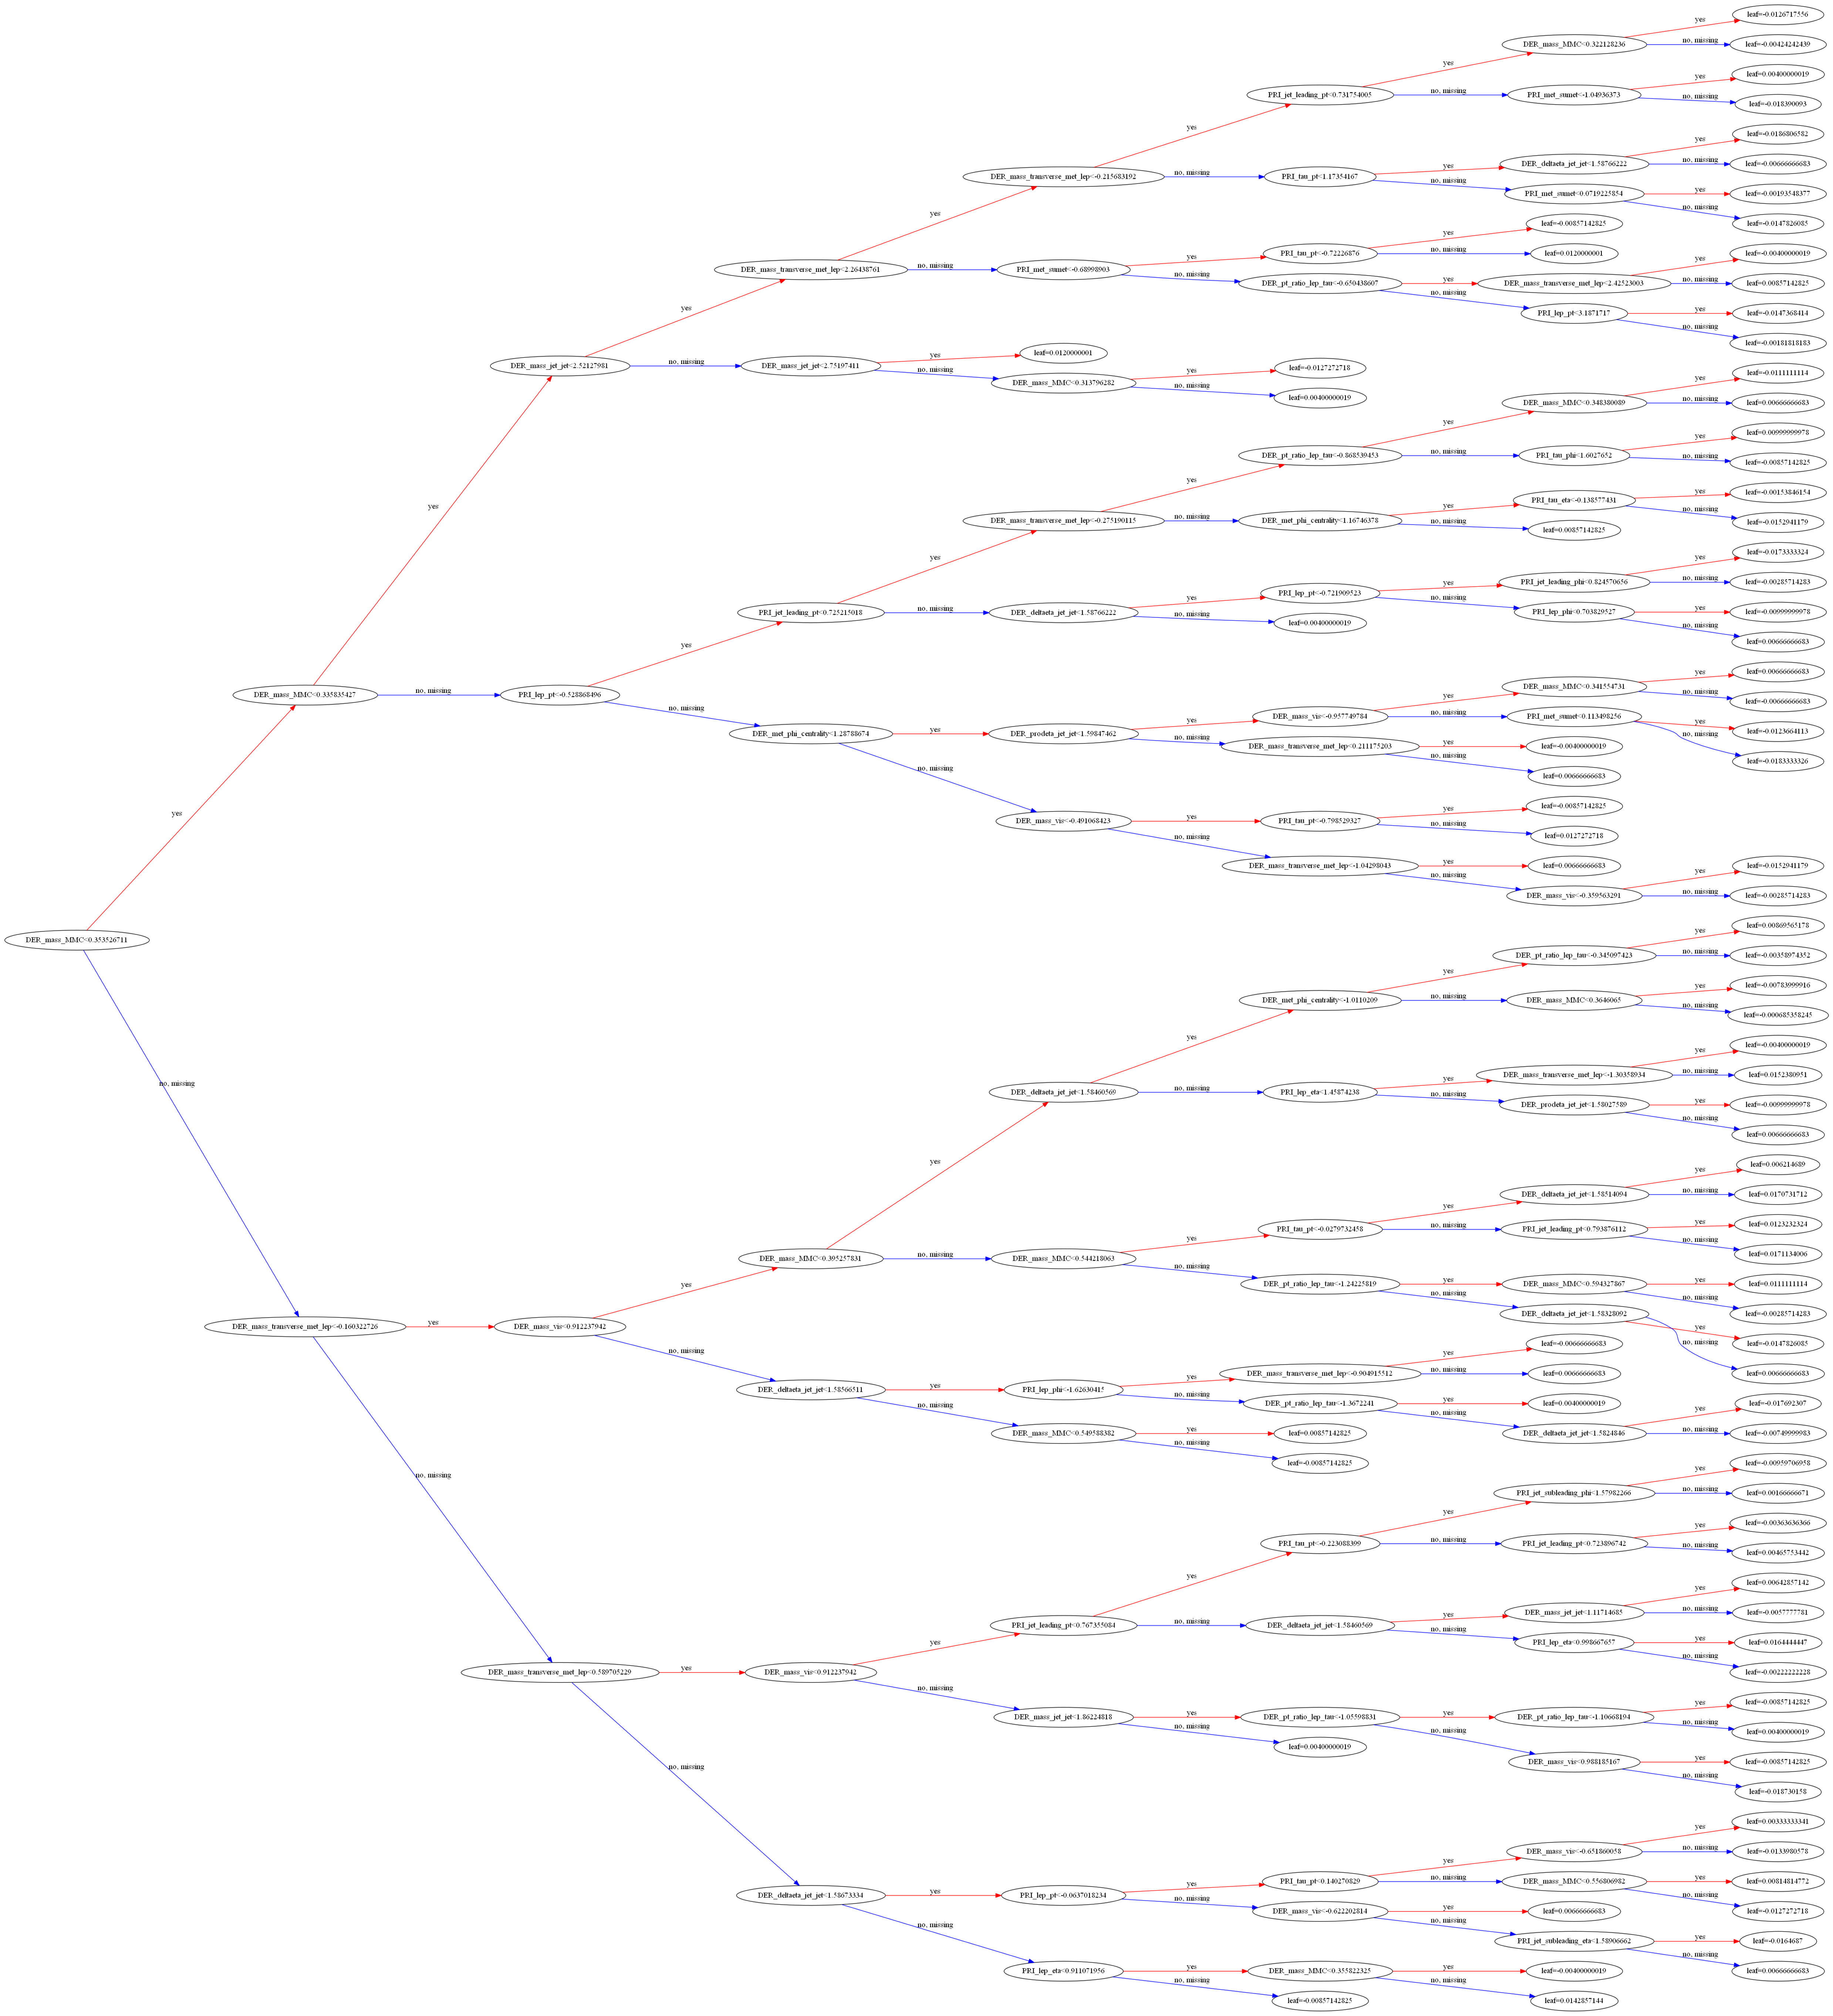

In [8]:
%%time
xgb_model = xgb.XGBClassifier(
    learning_rate     = 0.01,
    max_depth         = 7,
    n_estimators      = 1000,
    objective         = 'binary:logistic',
    base_score        = 0.5,
    booster           = 'gbtree',
    colsample_bytree  = 0.7,
    gamma             = 0,
    min_child_weight  = 0.0001,
    nthread           = 4,
    random_state      = 0,
    seed              = 1337,
    eval_metric       ='rmse',
    use_label_encoder = False,
    verbosity         = 0,
    tree_method       = 'gpu_hist',
    gpu_id            = 0,
    subsample         = 0.8
)
xgb_model.fit(X_train, y_train)
score = xgb_model.score(X_test, y_test)
xgb.plot_tree(xgb_model, rankdir='LR', fontsize='12')
fig = plt.gcf()
fig.set_size_inches(200, 100)
fig.savefig('tree.png')
print(score)


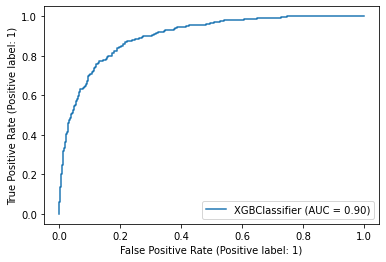

In [11]:
sklearn.metrics.RocCurveDisplay.from_estimator(xgb_model, X_test, y_test)

It is shown that XGBoost gives the best performance with relative longer runtime. The discrimination efficiency is very high because of a high similarity between the signal and background. Also, different decay mode of the boosted tau makes it harder to run a single estimator. It is expected to improve with more computing power, time, and extensive feature engineering based on physics knowledge.